### Task:
Use several classifiers to classify the test data to be positive or negative, and then evaluate the performance.
### Procedure:
Data visualization:
1. Show summary stats
2. Create some histograms and boxplots
3. Cluster the data

Data preprocessing:
1. Encode categorical values into integer.
2. Do one-of-K scheme encoding.
3. Split the data into training set and testing set.

Training: 
1. Train the decision tree model to find the best parameters for the model using 5 fold cross validation. That is, we search an optimal parameter combination in this parameter set {'criterion': ['entropy', 'gini'], 'max_depth': [5, 10, 15]}
2. We need to find the best threshold so that the model can classify test data based on this threshold. So we plot the ROC curve of training data, and then find the point on the ROC curve which is closest to top-left corner (0, 1). And we find its corresponding threshold (i.e., best_threshold). 

Evaluation:
1. Use the model to predict the test set, so we can get the probability of positive. Then we can plot ROC curve to see the area under ROC curve. And we can calculate the TPR (test_tpr) and FPR (test_fpr) of the test set, and then compare them to those of train set (best_fpr, best_tpr). Finally, based on the assumptions of Price and Cost, we can calculate the profit of the bank: # of TP \* (Price - Cost) - # of FP \* Cost

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn import preprocessing
import argparse
import numpy as np
import scipy
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.grid_search import ParameterGrid
import pylab as pl
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from scipy import interp
from sklearn.cross_validation import StratifiedKFold
import math
import sys
import itertools
from operator import itemgetter
from sklearn.feature_selection import RFECV
# from sklearn import tree
# from sklearn.externals.six import StringIO
# import pydot # don't use this.
# import pydotplus
# from IPython.display import Image
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Our assumptions on price and cost:

In [3]:
TERM_DEPOSIT_PRICE = 20
TERM_DEPOSIT_COST = 10

CONTACT_COST = 3
if TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST <= 0:
    print("Invalid input")

In [21]:
# dataset doesn't have month == 'jan' & 'feb'
raw_numeric_features = [
            'age',
            'duration',
            'campaign',
            'pdays',
            'previous',
            'emp.var.rate',
            'cons.price.idx',
            'cons.conf.idx',
            'euribor3m',
            'nr.employed']
raw_categorical_features = [['admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown_job'],
                            ['divorced','married','single','unknown_marital'],
                            ['basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown_education'],
                            ['no_default','yes_default','unknown_default'],
                            ['no_housing','yes_housing','unknown_housing'],
                            ['no_loan','yes_loan','unknown_loan'],
                            ['cellular','telephone'],
                            ['mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
                            ['mon','tue','wed','thu','fri'],
                            ['failure','nonexistent','success']]
feature_names = []
for categorical_feature in raw_categorical_features:
    feature_names += sorted(categorical_feature)
feature_names += raw_numeric_features
# print(len(feature_names))
# for i in feature_names:
#     print(i)
# print(feature_names)

               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198    

[<matplotlib.text.Text at 0x10f3bdf28>, <matplotlib.text.Text at 0x10f4ccba8>]

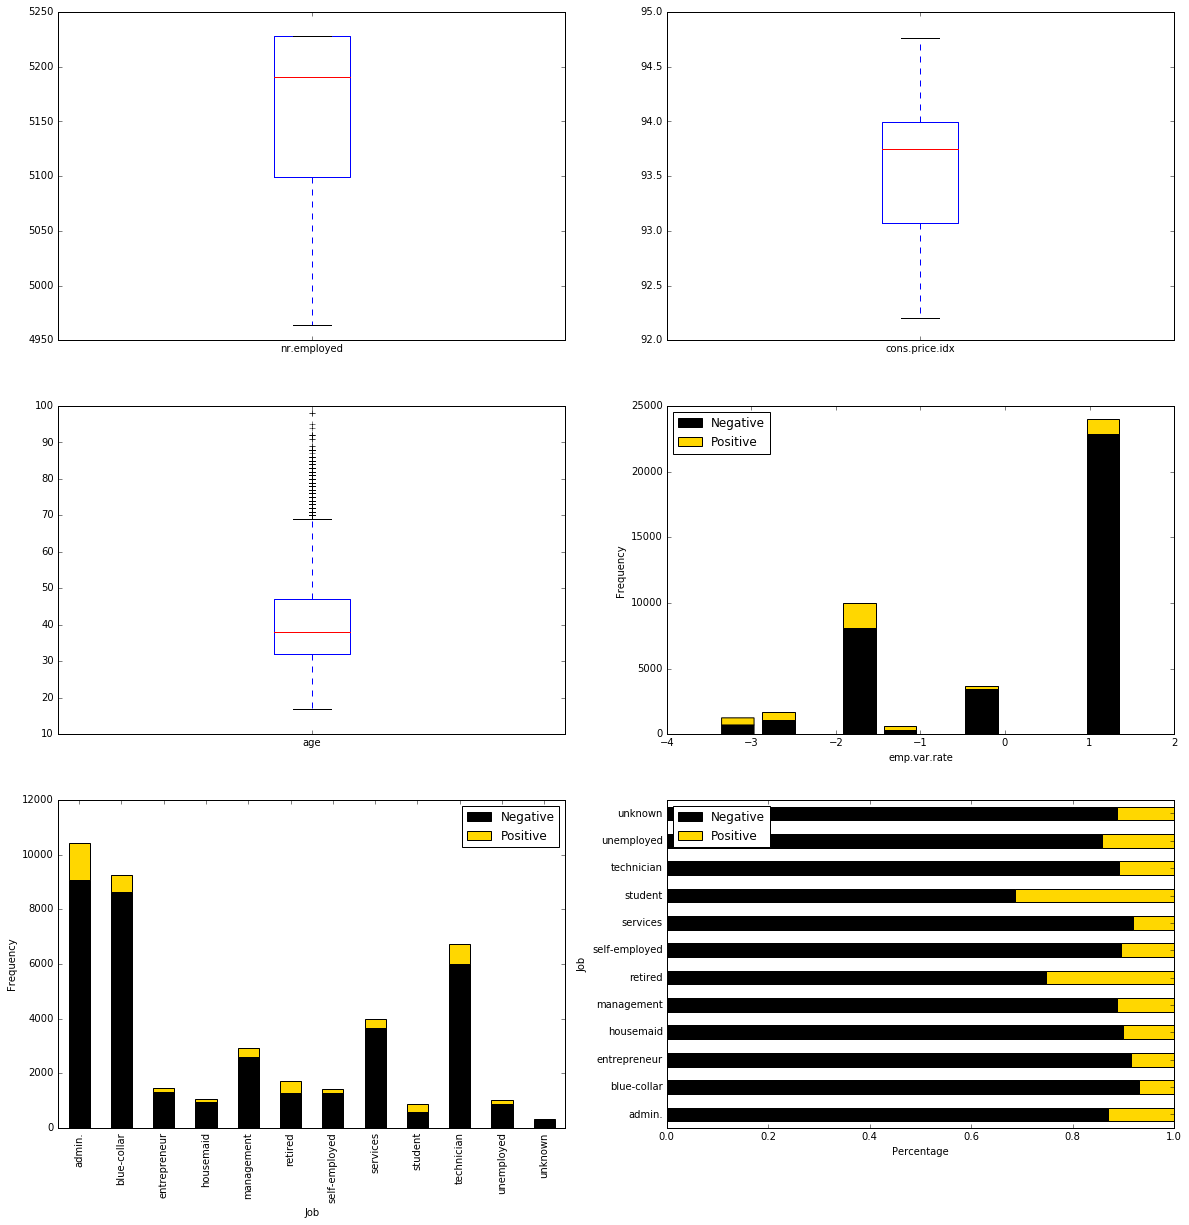

In [5]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';')

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
labels = ["Negative", "Positive"]

# show summary statistics
print(data.describe())

# Label Encoding. Encode y (target)
lab = preprocessing.LabelEncoder()
data.y = lab.fit_transform(data.y)

# visualize the data
data.boxplot(column='nr.employed', grid=False, ax=axs[0, 0], return_type='axes');
data.boxplot(column='cons.price.idx', grid=False, ax=axs[0, 1], return_type='axes');
data.boxplot(column='age', grid=False, ax=axs[1, 0], return_type='axes');


axs[1, 1].set(xlabel="emp.var.rate", ylabel="Frequency")
axs[1, 1].hist([data[data.y == 0]['emp.var.rate'], data[data.y == 1]['emp.var.rate']], stacked=True
               , color=['black','gold']);
axs[1, 1].legend(labels, loc='best')


yes_counts = pd.crosstab([data.job], data.y.astype(bool))
yes_counts.plot(kind='bar', stacked=True, color=['black', 'gold'], grid=False, ax=axs[2, 0])
axs[2, 0].legend(labels, loc='best')
axs[2, 0].set(xlabel="Job", ylabel="Frequency")

yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, color=['black','gold'], ax=axs[2, 1])
axs[2, 1].legend(labels, loc='best')
axs[2, 1].set(xlabel="Percentage", ylabel="Job")

Attribute 'pdays' is the number of days that passed by after the client was last contacted from a previous campaign. (999 means client was not previously contacted) From the summary statistics, we can see that there are many data whose 'pdays' equals 999. This means this dataset recorded many new clients.

I compared the number of positive and negative based on different employment variation rate (emp.var.rate). The result is in line with expectations. When the economics is bad (employment variation rate is smaller than -1), people tend to buy term deposit because its financial risk is small. When the economics is okay or good, people prefer not to buy term deposit because the profit of term deposit is not very high. They prefer to use their money to do other investments such as stocks.

I compared the number of positive and negative based on different jobs. The result is also reasonable. Retired people and students tend to buy term deposit because they usually don't have time or ability to do other investments. So they tend to choose a safe way to manage their money.

I also plotted some boxplots and the results also look reasonable. And we can see that this dataset also recorded some data with people at very high age.

Reduced dataset shape: (41188, 2)


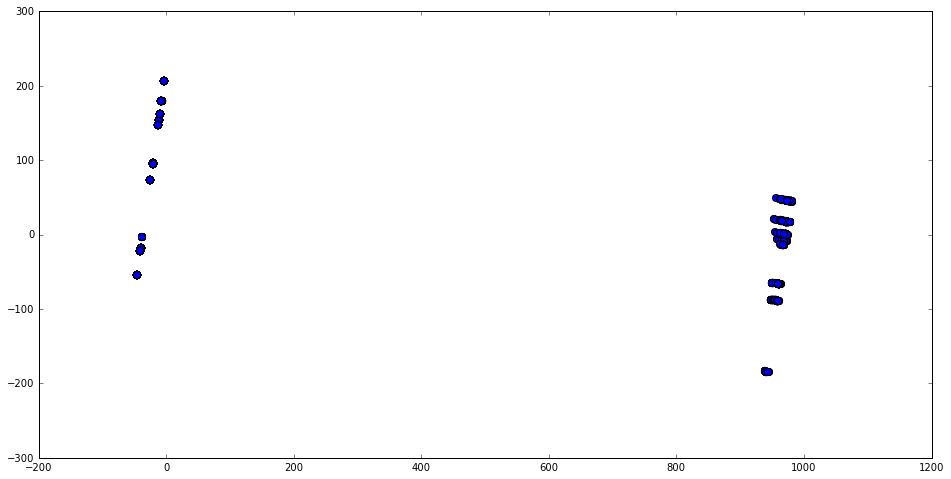

Meaning of the 2 components:
0.002 x age + -0.001 x campaign + -0.987 x pdays + 0.002 x previous + -0.003 x emp.var.rate + -0.000 x cons.price.idx + 0.002 x cons.conf.idx + -0.003 x euribor3m + -0.163 x nr.employed
0.001 x age + -0.005 x campaign + 0.163 x pdays + 0.002 x previous + -0.020 x emp.var.rate + -0.005 x cons.price.idx + -0.011 x cons.conf.idx + -0.023 x euribor3m + -0.986 x nr.employed


In [6]:
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
data_for_cluster = data.loc[:, numeric_features].values
pca = PCA(n_components=2)
pca.fit(data_for_cluster)
data_for_cluster_reduced = pca.transform(data_for_cluster)
print("Reduced dataset shape:", data_for_cluster_reduced.shape)

plt.figure(figsize=(16,8))
plt.scatter(data_for_cluster_reduced[:, 0], data_for_cluster_reduced[:, 1], s=50)
plt.show()

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name) 
                     for value, name in zip(component, numeric_features)))

Since the number of features is larger than 2, I use PCA to reduce to 2 features.

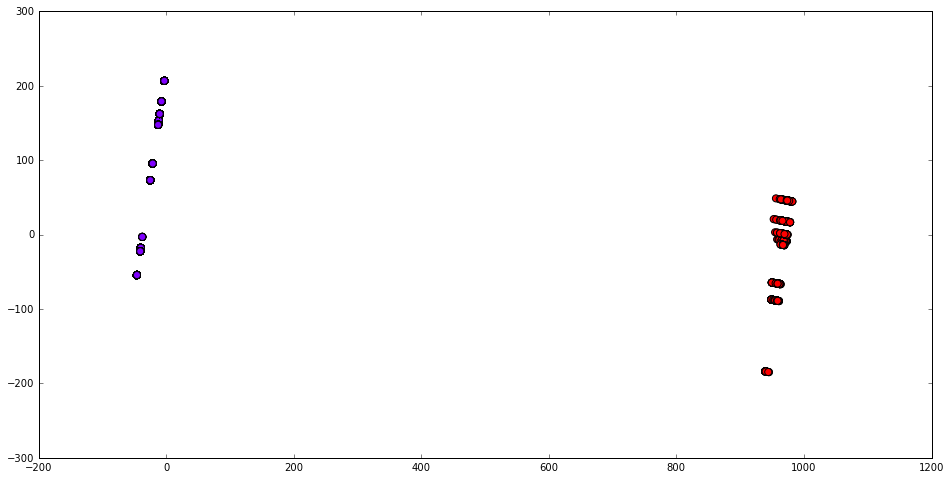

In [7]:
k_means = KMeans(n_clusters=2)
k_means.fit(data_for_cluster)
y_pred = k_means.predict(data_for_cluster)

plt.figure(figsize=(16,8))
plt.scatter(data_for_cluster_reduced[:, 0], data_for_cluster_reduced[:, 1], c=y_pred,
           cmap='rainbow', s=50)
plt.show()

I used K means algorithm to cluster the data. By the scatter plot, it's reasonable to choose k = 2. The two clusters identified by the algorithm are what I expect. I guess the reason why we have these 2 obvious clusters is because there are many data whose 'pdays' equals 999. So there is an obvious group around x = 999

In [8]:
def scale_numerical(data, features):
    k=0 # column index
    data_for_scale = data.values
    for i in data:  # for every column
        if i in features:
            min_i = min(data[i])
            max_i = max(data[i]) 
            #print(i,min_i,max_i)
            for j in range(len(data)):
                # after scale, x = (x-min[i])/(max[i]-min[i])   
                temp = data[i][j]*1.0
                data_for_scale[j,k] = (temp-min_i)/(max_i-min_i) 
        k += 1
    return data_for_scale 

In [9]:
# Encode categorical values into integer.
data.job = lab.fit_transform(data.job)
data.marital = lab.fit_transform(data.marital)
data.education = lab.fit_transform(data.education)
data.default = lab.fit_transform(data.default)
data.housing = lab.fit_transform(data.housing)
data.loan = lab.fit_transform(data.loan)
data.contact = lab.fit_transform(data.contact)
data.month = lab.fit_transform(data.month)
data['day_of_week'] = lab.fit_transform(data['day_of_week'])
data.poutcome = lab.fit_transform(data.poutcome)

In [10]:
features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'month', 'day_of_week','duration', 'campaign', 'pdays', 'previous',
        'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
        'euribor3m', 'nr.employed', 'y']
scaled_data_values = scale_numerical(data, raw_numeric_features) # an array with numerical values scaled
scaled_data = pd.DataFrame(scaled_data_values, columns = features) # transfer array to DataFrame
scaled_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,3,1,0,0,0,0,1,6,1,...,0,1,0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0
1,0.493827,7,1,3,1,0,0,1,6,1,...,0,1,0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0
2,0.246914,7,1,3,0,2,0,1,6,1,...,0,1,0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0
3,0.283951,0,1,1,0,0,0,1,6,1,...,0,1,0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0
4,0.481481,7,1,3,0,0,2,1,6,1,...,0,1,0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0


In [11]:
def split_data(data):
    features = data.as_matrix() # features shape: (41188, 21)
    target = features[:, 20]
    features_numeric = features[:, 0:20] # shape: (41188, 20) (index 20 won't be included)
    
    # One-k-scheme encoding
    cat_indices = np.array([[1,2,3,4,5,6,7,8,9,14]])
    enc = OneHotEncoder(categorical_features = cat_indices)
    encoded_features1 = enc.fit_transform(features_numeric)
    # print(enc.n_values_)
    # print(sum(enc.n_values_))
    # print("---------")
    # print(enc.feature_indices_)
    # print("---------")
    # matrix = encoded_features1.todense()
    # print(encoded_features1)
    # print(matrix)
    
    
    # Splitting data
    X_train, X_test, Y_train, Y_test = train_test_split(encoded_features1.todense(), 
                                                        target, test_size=0.4, random_state=0)
    print(X_train.shape)
    print(X_test.shape)
    return (X_train, X_test, Y_train, Y_test)

In [22]:
X_train, X_test, Y_train, Y_test = split_data(data)
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = split_data(scaled_data)
# print(X_train[0])

(24712, 63)
(16476, 63)
(24712, 63)
(16476, 63)


In [32]:
def run_classifier(classifier_id, X_train, X_test, Y_train, Y_test):    
    classifiers = (None, RandomForestClassifier, SGDClassifier, LogisticRegression, DecisionTreeClassifier)

    grid_RF = [{'max_depth': [5, 10, 15], 'criterion': ['entropy', 'gini'], 'n_estimators': [50, 100, 250], 'class_weight': ['balanced']}]
    
    grid_SGD = [{'loss': ('log', 'hinge'), 'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.001, 0.0001, 0.00001, 0.000001], 'class_weight': ['balanced']}]

    grid_LR = [{'C': [0.001,0.01,1, 10, 100, 1000], 'class_weight': ['balanced']}]

    grid_DT = [{'criterion': ['entropy', 'gini'], 'max_depth': [5, 10, 15]}]

    grids = (None, grid_RF, grid_SGD, grid_LR, grid_DT)
    grid_obj = grids[classifier_id]
    cls_obj = classifiers[classifier_id]

    best_param = None
    best_score = None
    best_model = None
    print ("Performing cross validation using parameter grid...")
    for one_param in ParameterGrid(grid_obj):
        cls = cls_obj(**one_param)

        one_score = cross_val_score(cls, X_train, Y_train, cv=5, scoring='roc_auc')
        mscore = one_score.mean()
        

        if ( best_score is None or best_score < mscore): 
            best_param = one_param
            best_score = mscore
            best_model = cls
    
    print("Best param: %s" % repr(best_param))


    classifier_name_list = (None, "RandomForestClassifier", "SGDClassifier", "Logistic Regression", "Decision Trees")
    best_model.fit(X_train, Y_train)
        
    best_params = get_best_model_params(best_model, X_train, Y_train, classifier_name_list[classifier_id])
    print("From training set, (best_fpr, best_tpr, best_threshold) = ")
    print(best_params)
    
    print("\n\nEvaluate on test set:")
    predict_test(best_model, X_test, Y_test, classifier_name_list[classifier_id], best_params)
    
    print("\nExplore important features:")
    explore_features_importance(best_model, classifier_name_list[classifier_id], X_train)
    

        
    
def explore_features_importance(best_model, classifier_name, X_train):
    if classifier_name == 'Decision Trees' or classifier_name == "RandomForestClassifier":
        importance_to_idx = []
        # print("feature_importances_ = ")
        # print(best_model.feature_importances_)
        feature_importances = best_model.feature_importances_
        
        for idx in range(len(feature_importances)):
            importance_to_idx.append((feature_importances[idx], idx))
        sort_importance_to_idx = sorted(importance_to_idx, key=itemgetter(0), reverse=True)

        print("From most important feature to least important feature (only show top 10): ")
        counter = 0
        for item in sort_importance_to_idx:
            print(feature_names[item[1]] + ': ' + str(item[0]))      
            counter += 1
            if counter == 10:
                break;            
    else: 
#         coef = []
#         for co in best_model.coef_[0]:
#             coef.append(co)
#         feature_importances = coef

        ranking_to_idx = []
    
        selector = RFECV(best_model, cv=5)
        selector = selector.fit(X_train, Y_train)
        print("selector.support_ = ")
        print(selector.support_)
        
        rankings = selector.ranking_
        for idx in range(len(rankings)):
            ranking_to_idx.append((rankings[idx], idx))
        sort_ranking_to_idx = sorted(ranking_to_idx, key=itemgetter(0))
        print("From most important feature to least important feature (only show top 10):")
        counter = 0
        for item in sort_ranking_to_idx:
            print(feature_names[item[1]] + ': ' + str(item[0]) + "th important")        
            counter += 1
            if counter == 10:
                break;


#         latest try
#         dot_data = StringIO()
#         tree.export_graphviz(best_model, out_file=dot_data)

#         ----------------
#         tree.export_graphviz(best_model, out_file='decision_tree.dot')        
#         graph = pydot.graph_from_dot_data(dot_data.getvalue())
#         ----------------

#         latest try
#         graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#         ----------------    
#         graph.write_pdf("tree.pdf")
#         ----------------

#         latest try
#         Image(graph.create_png())
    #elif classifier_name == 'Logistic Regression':
        #result = best_model.transform(X_train)
        #print(best_model.coef_)
#         TODO: what does the result mean?

        #print("RESULT:")
        #print(len(result))
        #print(len(result[0]))
        #print(result)

    
def predict_test(best_model, x_data, y_data, classifier_name, best_params):
    if classifier_name == 'SGDClassifier':
        confidence_score = best_model.decision_function(x_data)
        fpr, tpr, thresholds = roc_curve(y_data, confidence_score)
    else:
        probas_ = best_model.predict_proba(x_data) # len(probas_) = size of testing set
        fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)
    

    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)    
    
    print("\nAssess the model based on best_threshold:")
    best_threshold = best_params[2]    
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in zip(y_data, confidence_score if classifier_name == 'SGDClassifier' else probas_[:, 1]):
        if item[0] == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        if item[1] >= best_threshold:
            # predict as positive            
            if item[0] == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr = fp / tn_plus_fp
    test_tpr = tp / tp_plus_fn
    print("(test_fpr, test_tpr) = ")
    print((test_fpr, test_tpr))
    
    print("fp = ")
    print(fp)
    print("tp = ")
    print(tp)

    cost = fp * CONTACT_COST - tp * (TERM_DEPOSIT_PRICE - TERM_DEPOSIT_COST - CONTACT_COST)   
    print("Using this best model to do predictions on test set, the profit of the bank is %s USD.\n" % str(-1 * cost))
    
    
def get_best_model_params(best_model, x_data, y_data, classifier_name):
    if classifier_name == 'SGDClassifier':
        confidence_score = best_model.decision_function(x_data)
        fpr, tpr, thresholds = roc_curve(y_data, confidence_score)
    else:
        probas_ = best_model.predict_proba(x_data) # len(probas_) = size of training set
        fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)

    
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)

    
    # find best params
    best_fpr = None
    best_tpr = None
    best_threshold = None
    min_distance = sys.maxsize
    for item in zip(fpr, tpr, thresholds):
        distance = math.sqrt(math.pow(item[0], 2) + math.pow(item[1] - 1, 2))
        if min_distance > distance:
            min_distance = distance
            best_fpr = item[0]
            best_tpr = item[1]
            best_threshold = item[2]    
    
    return (best_fpr, best_tpr, best_threshold)
    

def plot_roc_curve(fpr, tpr, roc_auc, classifier_name):
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('Receiver operating characteristic- %s' % classifier_name)
    pl.legend(loc="lower right")
    pl.show()    

Performing cross validation using parameter grid...
Best param: {'class_weight': 'balanced', 'C': 1}
Area under the ROC curve : 0.937315


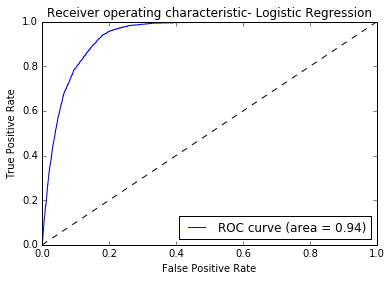

From training set, (best_fpr, best_tpr, best_threshold) = 
(0.15137258484447083, 0.89499822632139059, 0.47815938288283205)


Evaluate on test set:
Area under the ROC curve : 0.938474


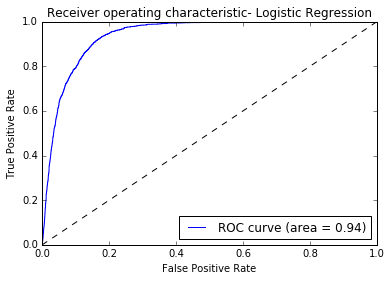


Assess the model based on best_threshold:
(test_fpr, test_tpr) = 
(0.1451381780962129, 0.8896210873146623)
fp = 
2127
tp = 
1620
Using this best model to do predictions on test set, the profit of the bank is 4959 USD.


Explore important features:
selector.support_ = 
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False]
From most important feature to least important feature (only show top 10):
success: 1th important
mar: 2th important
dec: 3th important
oct: 4th important
student: 5th important
illiterate: 6th important
retired: 7th important
may: 8th important
euribor3m: 9th important
no_housing: 10th important


In [24]:
run_classifier(3, X_train, X_test, Y_train, Y_test)

Performing cross validation using parameter grid...
Best param: {'class_weight': 'balanced', 'C': 10}
Area under the ROC curve : 0.937476


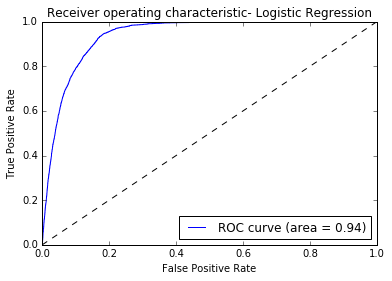

From training set, (best_fpr, best_tpr, best_threshold) = 
(0.16557803864248846, 0.92302234835047892, 0.42543424256719209)


Evaluate on test set:
Area under the ROC curve : 0.938464


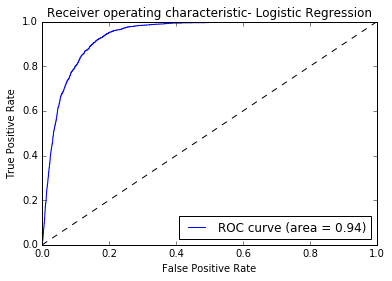


Assess the model based on best_threshold:
(test_fpr, test_tpr) = 
(0.16110542476970316, 0.9137836353651839)
fp = 
2361
tp = 
1664
Using this best model to do predictions on test set, the profit of the bank is 4565 USD.


Explore important features:
selector.support_ = 
[False  True False False False  True  True  True  True False False False
 False False False  True False False False False  True False False False
  True False False False  True False False  True False  True False False
  True False False  True  True  True  True False  True False False False
 False False  True False  True False  True  True  True  True  True  True
 False  True  True]
From most important feature to least important feature (only show top 10):
blue-collar: 1th important
retired: 1th important
self-employed: 1th important
services: 1th important
student: 1th important
unknown_marital: 1th important
illiterate: 1th important
no_default: 1th important
unknown_housing: 1th important
unknown_loan: 1th important


In [25]:
#scale numerical 
run_classifier(3, X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled)

Performing cross validation using parameter grid...
Best param: {'penalty': 'l1', 'class_weight': 'balanced', 'alpha': 0.001, 'loss': 'hinge'}
Area under the ROC curve : 0.878549


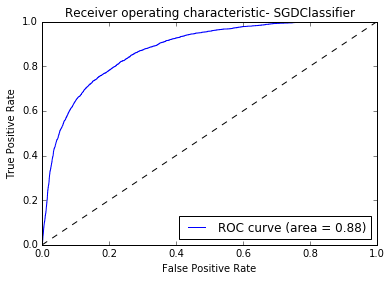

From training set, (best_fpr, best_tpr, best_threshold) = 
(0.22377015484401408, 0.80879744590280245, -523441.54048100766)


Evaluate on test set:
Area under the ROC curve : 0.884280


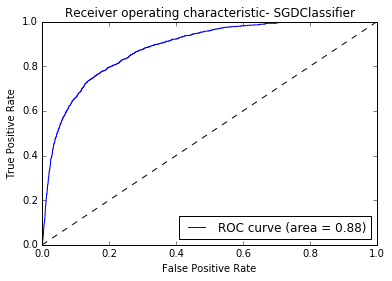


Assess the model based on best_threshold:
(test_fpr, test_tpr) = 
(0.21794609348345276, 0.8072487644151565)
fp = 
3194
tp = 
1470
Using this best model to do predictions on test set, the profit of the bank is 708 USD.


Explore important features:
selector.support_ = 
[False  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True]
From most important feature to least important feature (only show top 10):
blue-collar: 1th important
entrepreneur: 1th important
housemaid: 1th important
management: 1th important
retired: 1th important
self-employed: 1th important
services: 1th important
student: 1th important
technician: 1th important
unemployed: 1th important


In [35]:
run_classifier(2, X_train, X_test, Y_train, Y_test)

Performing cross validation using parameter grid...
Best param: {'criterion': 'entropy', 'max_depth': 5}
Area under the ROC curve : 0.936357


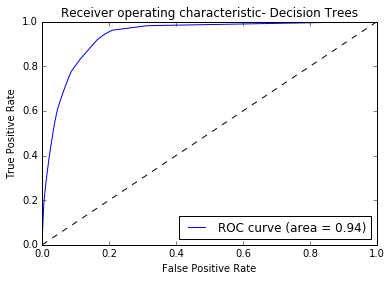

From training set, (best_fpr, best_tpr, best_threshold) = 
(0.14899739642808205, 0.89286981199006743, 0.18133616118769882)


Evaluate on test set:
Area under the ROC curve : 0.930706


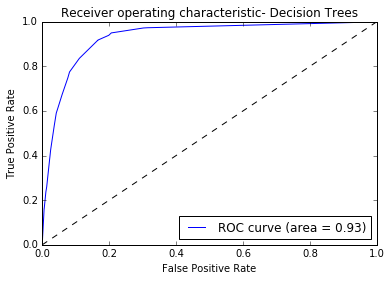


Assess the model based on best_threshold:
(test_fpr, test_tpr) = 
(0.1501194131695667, 0.8929159802306426)
fp = 
2200
tp = 
1626
Using this best model to do predictions on test set, the profit of the bank is 4782 USD.


Explore important features:
From most important feature to least important feature (only show top 10): 
duration: 0.498082136516
nr.employed: 0.330779698549
cons.conf.idx: 0.0897164746142
pdays: 0.0284290394666
euribor3m: 0.0233282897285
oct: 0.018671103747
cons.price.idx: 0.0031764293513
may: 0.00242062904584
campaign: 0.00196161773235
telephone: 0.00141557499579


In [26]:
run_classifier(4, X_train, X_test, Y_train, Y_test)

Performing cross validation using parameter grid...
Best param: {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 250, 'max_depth': 15}
Area under the ROC curve : 0.994027


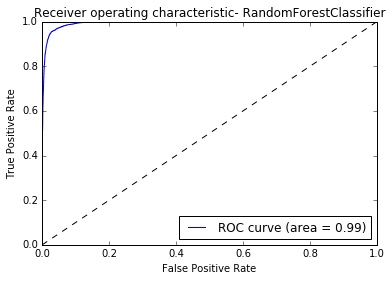

From training set, (best_fpr, best_tpr, best_threshold) = 
(0.033709404832594894, 0.95991486342674703, 0.55908369660803192)


Evaluate on test set:
Area under the ROC curve : 0.944845


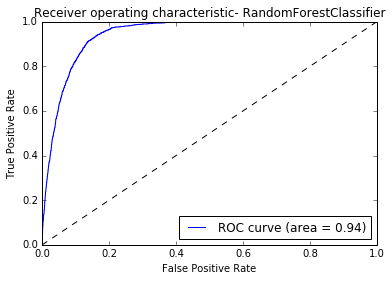


Assess the model based on best_threshold:
(test_fpr, test_tpr) = 
(0.0593654042988741, 0.6771004942339374)
fp = 
870
tp = 
1233
Using this best model to do predictions on test set, the profit of the bank is 6021 USD.


Explore important features:
From most important feature to least important feature (only show top 10): 
duration: 0.370628626236
euribor3m: 0.0935437241887
nr.employed: 0.0679256001434
emp.var.rate: 0.0561288457032
age: 0.039231957051
cons.conf.idx: 0.0329831608312
cons.price.idx: 0.0321325162818
pdays: 0.0318319479692
campaign: 0.0227619849448
may: 0.0135920253702


In [34]:
run_classifier(1, X_train, X_test, Y_train, Y_test)

In [220]:
data = [('a', 121),('b', 231),('c', 148), ('d',221)]
sorted(data,key=itemgetter(1))
print(data)
print(data[1][0])

[('a', 121), ('b', 231), ('c', 148), ('d', 221)]
b


In [221]:
x = range(3)
for i in x:
    print(i)

0
1
2


In [222]:
print('d' + "a")

da
